<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21263194/Change4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [3]:
# Load the IMDB dataset with num_words=10000
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

# Set a maximum length for reviews (e.g., 200 words)
maxlen = 200

# Pad sequences so that they all have the same length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Display the shape of training and testing data
print(f"Training entries: {len(X_train)}, labels: {len(y_train)}")
print(f"Test entries: {len(X_test)}, labels: {len(y_test)}")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training entries: 25000, labels: 25000
Test entries: 25000, labels: 25000


In [4]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [6]:
import gensim.downloader as api

# Download and load a small pre-trained model directly from Gensim
word_vectors = api.load('glove-wiki-gigaword-50')  # Example using a small GloVe model (50d)

# Check word embedding for a sample word
print(word_vectors['king'])


[==================================================] 100.0% 66.0/66.0MB downloaded
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]


In [7]:

# Create an embedding matrix for the IMDB dataset using the pretrained GloVe embeddings
embedding_dim = 50  # Since we're using GloVe 50d
vocab_size = num_words

embedding_matrix = torch.zeros((vocab_size, embedding_dim))
for word, index in imdb.get_word_index().items():
    if index < vocab_size:  # Ensure that we're within the vocab size limit
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[index] = torch.tensor(embedding_vector)
        except KeyError:
            pass  # If word not found in GloVe, we keep it as zeros

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
class MultiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_sizes, output_size, dropout, pretrained_embeddings):
        super(MultiLSTM, self).__init__()

        # Embedding layer with pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)

        # Define multiple LSTM layers
        self.lstm1 = nn.LSTM(embed_size, hidden_sizes[0], batch_first=True)
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        self.lstm3 = nn.LSTM(hidden_sizes[1], hidden_sizes[2], batch_first=True)

        # Define dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_sizes[2], output_size)

        # Sigmoid activation for the final output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through embedding layer
        embeds = self.embedding(x)

        # First LSTM layer with tanh activation on output
        lstm_out1, (h_n1, c_n1) = self.lstm1(embeds)
        lstm_out1_activated = torch.tanh(lstm_out1)

        # Second LSTM layer with relu activation on output
        lstm_out2, (h_n2, c_n2) = self.lstm2(lstm_out1_activated)
        lstm_out2_activated = torch.relu(lstm_out2)

        # Third LSTM layer with sigmoid activation on output
        lstm_out3, (h_n3, c_n3) = self.lstm3(lstm_out2_activated)
        lstm_out3_activated = torch.sigmoid(lstm_out3)

        # Apply dropout to the output of the last LSTM cell
        out = self.dropout(lstm_out3_activated[:, -1, :])

        # Pass through fully connected layer
        out = self.fc(out)

        # Apply sigmoid activation to get the final output
        return self.sigmoid(out)

# Model hyperparameters
embed_size = 50  # GloVe embedding size (50d)
hidden_sizes = [128, 64, 32]  # Hidden sizes for each LSTM layer
output_size = 1  # Binary classification
dropout = 0.5

In [9]:

# Instantiate the model with pretrained embeddings
model = MultiLSTM(vocab_size, embed_size, hidden_sizes, output_size, dropout, embedding_matrix)


In [10]:

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training and evaluation setup
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set model to training mode
    train_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            outputs = model(X_batch).squeeze(1)

            # Compute loss
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return train_losses

In [12]:

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze(1)
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

In [13]:
# Hyperparameters
vocab_size = 10000  # For IMDB dataset, we use 10,000 most common words
embed_size = 50  # Embedding size (matches the size of our pretrained embeddings)
hidden_sizes = [128, 64, 32]  # Hidden layer sizes for each LSTM layer
output_size = 1  # Binary classification
dropout = 0.5  # Dropout rate

# Load pre-trained embeddings (replace this with actual embeddings)
# Assuming `embedding_matrix` contains your pretrained embeddings
# Example: embedding_matrix = torch.randn(vocab_size, embed_size)
embedding_matrix = torch.randn(vocab_size, embed_size)

# Instantiate the model
model = MultiLSTM(vocab_size, embed_size, hidden_sizes, output_size, dropout, embedding_matrix)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data preparation (you can load your dataset here)
# Assume `X_train`, `y_train`, `X_test`, and `y_test` have been prepared

batch_size = 64
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Train the model
num_epochs = 5
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/5], Loss: 0.6948
Epoch [2/5], Loss: 0.6942
Epoch [3/5], Loss: 0.6824
Epoch [4/5], Loss: 0.6283
Epoch [5/5], Loss: 0.5404


Test Accuracy: 0.7501


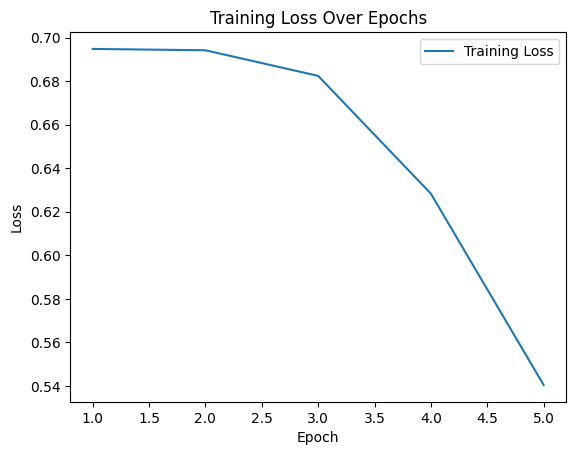

In [14]:
# Evaluate the model
test_accuracy = evaluate_model(model, test_loader)

# Plot training loss over epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()